In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 导入 alpha_utils 模块中的函数
import sys
from pathlib import Path
project_dir = Path().resolve().parent
sys.path.append(str(project_dir))
from alpha_utils import *

sns.set_style('whitegrid')
pd.options.display.float_format = '{:,.2f}'.format

### Import & Process data

In [2]:
data = pd.read_pickle('../data/merged_df.pkl')
print(f"# Symbols: {len(data.index.unique('symbol')):,.0f} | # Dates: {len(data.index.unique('Date')):,.0f}")
data.info()

# Symbols: 20 | # Dates: 6,769
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 182763 entries, ('ADAUSDT', Timestamp('2024-07-01 00:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-09 00:00:00+0000', tz='UTC'))
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Open          182763 non-null  float64
 1   High          182763 non-null  float64
 2   Low           182763 non-null  float64
 3   Close         182763 non-null  float64
 4   Volume        182763 non-null  float64
 5   id            175994 non-null  object 
 6   symbol_meta   175994 non-null  object 
 7   name          175994 non-null  object 
 8   market_cap    175994 non-null  float64
 9   total_volume  175994 non-null  float64
dtypes: float64(7), object(3)
memory usage: 14.5+ MB


In [3]:
print("Symbols include: ", list(data.index.levels[0]))

Symbols include:  ['ADAUSDT', 'BNBUSDT', 'BTCUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'ICXUSDT', 'IOTAUSDT', 'LINKUSDT', 'LTCUSDT', 'NEOUSDT', 'NULSUSDT', 'ONTUSDT', 'QTUMUSDT', 'TRXUSDT', 'TUSDUSDT', 'USDCUSDT', 'VETUSDT', 'XLMUSDT', 'XRPUSDT']


In [4]:
# remove duplicates
duplicates = data.index.duplicated()
print(data[duplicates].index.unique('symbol'))
data = data[~data.index.duplicated()]
data.info()

Index(['EOSUSDT', 'ETHUSDT', 'USDCUSDT'], dtype='object', name='symbol')
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135380 entries, ('ADAUSDT', Timestamp('2024-07-01 00:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-09 00:00:00+0000', tz='UTC'))
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Open          135380 non-null  float64
 1   High          135380 non-null  float64
 2   Low           135380 non-null  float64
 3   Close         135380 non-null  float64
 4   Volume        135380 non-null  float64
 5   id            128611 non-null  object 
 6   symbol_meta   128611 non-null  object 
 7   name          128611 non-null  object 
 8   market_cap    128611 non-null  float64
 9   total_volume  128611 non-null  float64
dtypes: float64(7), object(3)
memory usage: 10.8+ MB


In [5]:
by_symbol = data.groupby(level='symbol')

In [6]:
# Forward returns
T = [1, 2, 3, 4, 5, 12, 24, 48, 72]
for t in T:
    data[f'ret_{t:02}'] = - by_symbol.Close.pct_change(-t)

In [ ]:
# Backward returns (pct change)
T = [1, 2, 3, 4, 5, 12, 24, 48, 72]
for t in T:
    data[f'change_{t:02}'] = by_symbol.Close.pct_change(t)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135380 entries, ('ADAUSDT', Timestamp('2024-07-01 00:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-09 00:00:00+0000', tz='UTC'))
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Open          135380 non-null  float64
 1   High          135380 non-null  float64
 2   Low           135380 non-null  float64
 3   Close         135380 non-null  float64
 4   Volume        135380 non-null  float64
 5   id            128611 non-null  object 
 6   symbol_meta   128611 non-null  object 
 7   name          128611 non-null  object 
 8   market_cap    128611 non-null  float64
 9   total_volume  128611 non-null  float64
 10  ret_01        135360 non-null  float64
 11  ret_02        135340 non-null  float64
 12  ret_03        135320 non-null  float64
 13  ret_04        135300 non-null  float64
 14  ret_05        135280 non-null  float64
 15  ret_12        135140 no

In [ ]:
o = data.Open.unstack('symbol')
h = data.High.unstack('symbol')
l = data.Low.unstack('symbol')
c = data.Close.unstack('symbol')
v = data.Volume.unstack('symbol')
vwap = o.add(h).add(l).add(c).div(4)
adv20 = v.rolling(20).mean()
r = data.change_01.unstack('symbol')

### Alpha 009
```
(0 < ts_min(ts_delta(close, 1), 5)) ? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 5) < 0) 
? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))
```

In [9]:
alpha = 9

In [10]:
def alpha009(c):
    """(0 < ts_min(ts_delta(close, 1), 5)) ? ts_delta(close, 1) 
    : ((ts_max(ts_delta(close, 1), 5) < 0) 
    ? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))
    """
    close_diff = ts_delta(c, 1)
    alpha = close_diff.where(ts_min(close_diff, 5) > 0,
                             close_diff.where(ts_max(close_diff, 5) < 0,
                                              -close_diff))
    return (alpha
            .stack('symbol')
            .swaplevel())

In [11]:
ret_col = [c for c in data.columns if 'ret_' in c] + ['Close']
alphas = data[ret_col].copy()
alphas.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135380 entries, ('ADAUSDT', Timestamp('2024-07-01 00:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-09 00:00:00+0000', tz='UTC'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ret_01  135360 non-null  float64
 1   ret_02  135340 non-null  float64
 2   ret_03  135320 non-null  float64
 3   ret_04  135300 non-null  float64
 4   ret_05  135280 non-null  float64
 5   ret_12  135140 non-null  float64
 6   ret_24  134900 non-null  float64
 7   ret_48  134420 non-null  float64
 8   ret_72  133940 non-null  float64
 9   Close   135380 non-null  float64
dtypes: float64(10)
memory usage: 10.8+ MB


In [12]:
# %%time
alphas[f'{alpha:03}'] = alpha009(c)

In [13]:
alphas.dropna(inplace=True)

In [14]:
alphas.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 133920 entries, ('ADAUSDT', Timestamp('2024-07-01 01:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-06 00:00:00+0000', tz='UTC'))
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ret_01  133920 non-null  float64
 1   ret_02  133920 non-null  float64
 2   ret_03  133920 non-null  float64
 3   ret_04  133920 non-null  float64
 4   ret_05  133920 non-null  float64
 5   ret_12  133920 non-null  float64
 6   ret_24  133920 non-null  float64
 7   ret_48  133920 non-null  float64
 8   ret_72  133920 non-null  float64
 9   Close   133920 non-null  float64
 10  009     133920 non-null  float64
dtypes: float64(11)
memory usage: 11.7+ MB


#### Alpha trend visualization

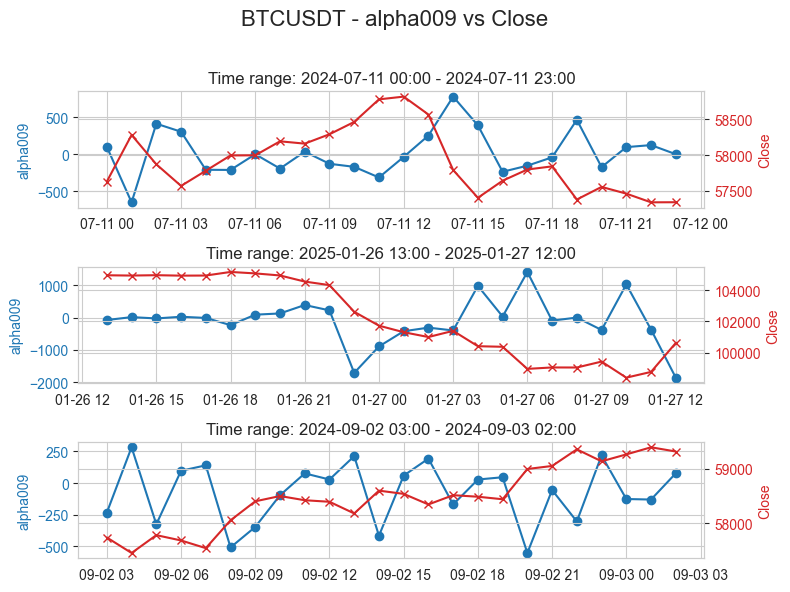

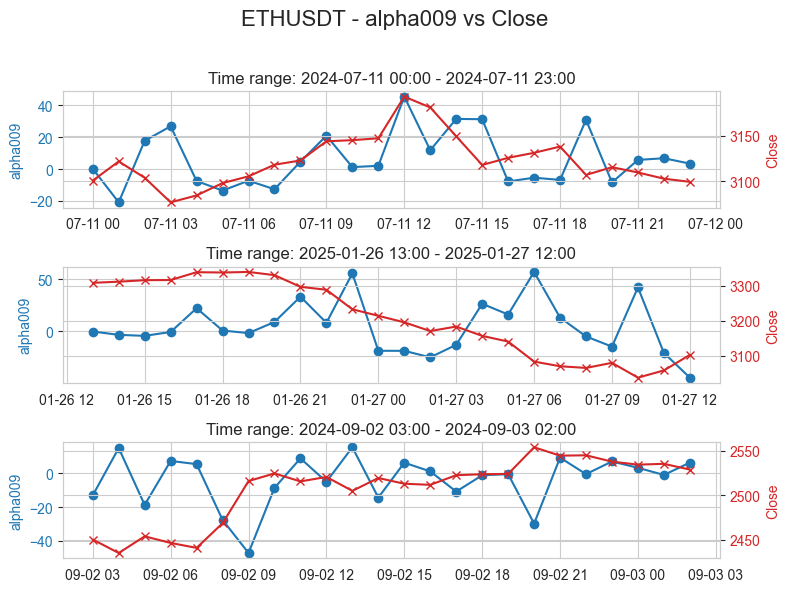

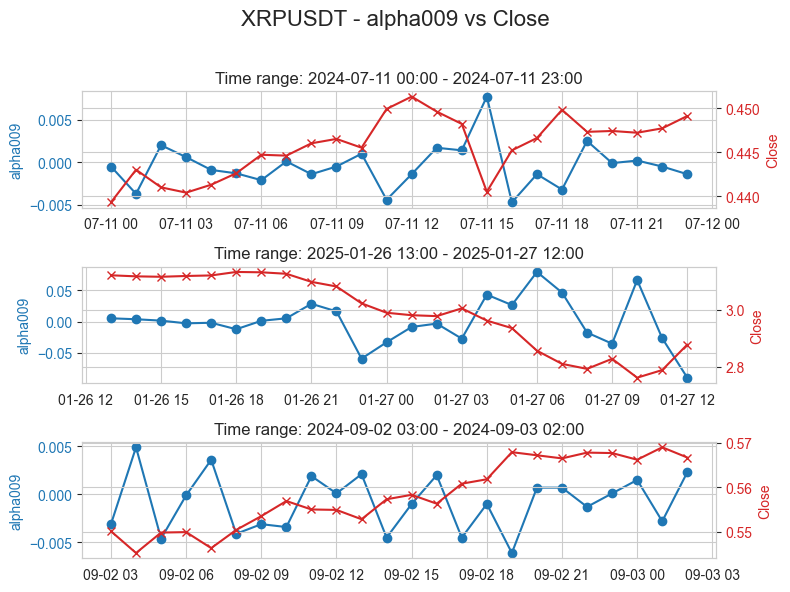

In [15]:
# 假设数据已经在 df 中
symbols = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT']

# 随机选取3个24小时的时间段
np.random.seed(42)
timestamps = alphas.index.get_level_values('Date').unique()
start_indices = np.random.choice(len(timestamps) - 24, size=3, replace=False)

time_ranges = [(timestamps[i], timestamps[i+23]) for i in start_indices]

# 开始绘图
for symbol in symbols:
    fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=False)
    fig.suptitle(f'{symbol} - alpha{alpha:03} vs Close', fontsize=16)

    for idx, (start, end) in enumerate(time_ranges):
        temp_df = alphas.loc[symbol].loc[start:end]

        ax1 = axs[idx]
        ax1.plot(temp_df.index, temp_df[f'{alpha:03}'], label=f'alpha{alpha:03}', color='tab:blue', marker='o')
        ax1.set_ylabel(f'alpha{alpha:03}', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(temp_df.index, temp_df['Close'], label='Close', color='tab:red', marker='x')
        ax2.set_ylabel('Close', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        ax1.set_title(f'Time range: {start.strftime("%Y-%m-%d %H:%M")} - {end.strftime("%Y-%m-%d %H:%M")}', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

#### Distribution visualization

KeyboardInterrupt: 

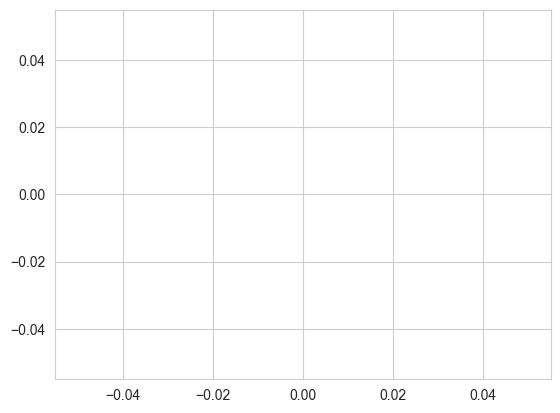

In [16]:
sns.histplot(alphas[f"{alpha:03}"])

In [18]:
alphas['009'].describe()

count   133,920.00
mean         -0.15
std         104.57
min      -5,142.30
25%          -0.00
50%          -0.00
75%           0.00
max       4,402.67
Name: 009, dtype: float64

KeyboardInterrupt: 

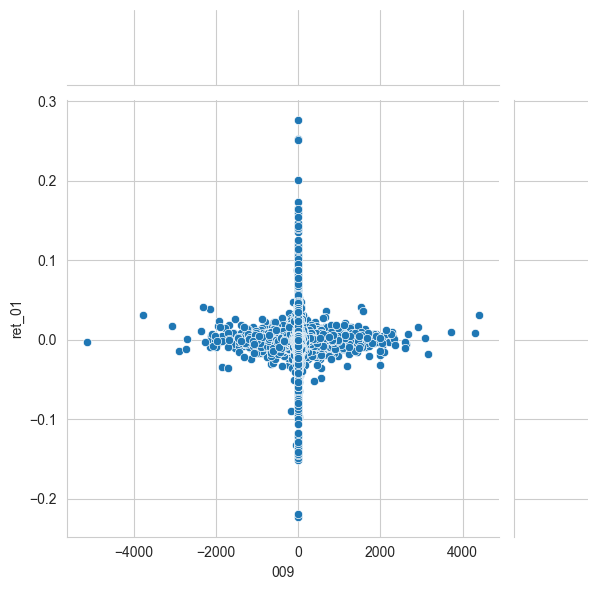

In [17]:
g = sns.jointplot(x=f"{alpha:03}", y='ret_01', data=alphas)

#### Correlation with future return

In [19]:
for c in ret_col:
    print(f"Corr between alpha{alpha:03} and {c} is:", alphas[f"{alpha:03}"].corr(alphas[c]))

Corr between alpha009 and ret_01 is: 0.002671296525784759
Corr between alpha009 and ret_02 is: 0.0010727337960469896
Corr between alpha009 and ret_03 is: 0.0029997019290091353
Corr between alpha009 and ret_04 is: 0.0028255748364149776
Corr between alpha009 and ret_05 is: 0.0018791309160285507
Corr between alpha009 and ret_12 is: 0.002574785668525459
Corr between alpha009 and ret_24 is: 0.004132358669279891
Corr between alpha009 and ret_48 is: 0.0020762695481144075
Corr between alpha009 and ret_72 is: 0.0007722662053441325
Corr between alpha009 and Close is: -0.007813353674165958


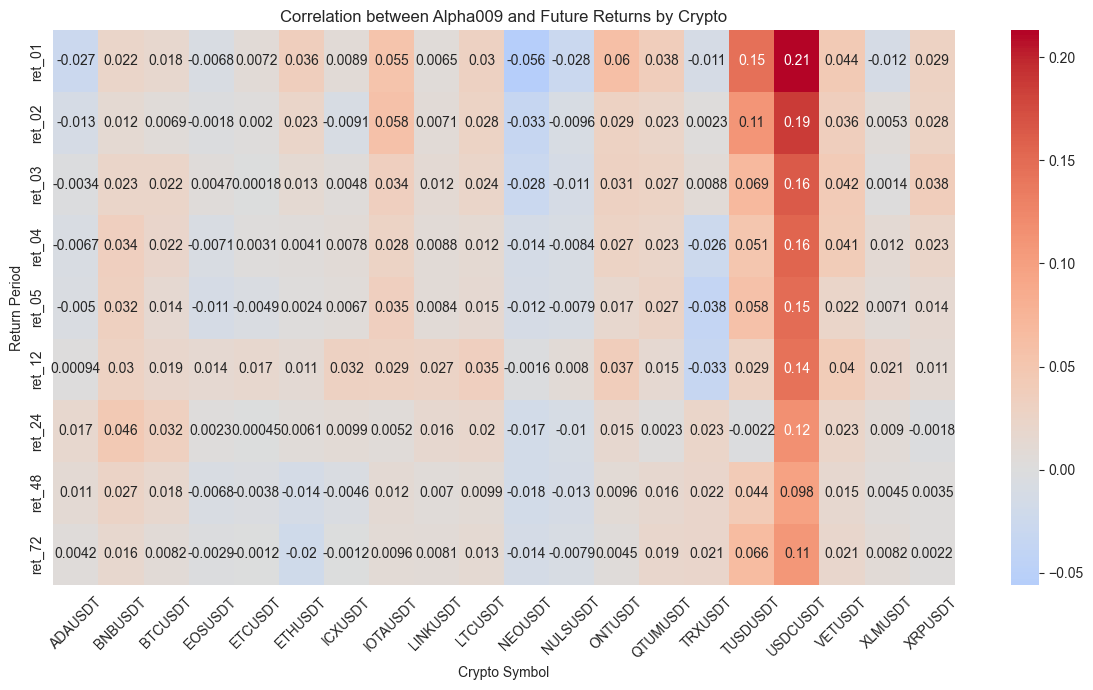

In [20]:
analysis_cols = ['ret_01', 'ret_02', 'ret_03', 'ret_04', 'ret_05', 'ret_12', 'ret_24', 'ret_48', 'ret_72', f'{alpha:03}']

# 初始化一个空的DataFrame用于存储每个币种的相关系数
symbols = alphas.index.get_level_values('symbol').unique()
correlation_results = pd.DataFrame(index=['ret_01', 'ret_02', 'ret_03', 'ret_04', 'ret_05', 'ret_12', 'ret_24', 'ret_48', 'ret_72'], 
                                   columns=symbols)

# 逐个币种计算相关系数
for symbol in symbols:
    temp_df = alphas.loc[symbol, analysis_cols].dropna()
    correlations = temp_df.corr()[f'{alpha:03}'].drop(f'{alpha:03}')
    correlation_results[symbol] = correlations

# 可视化热力图
plt.figure(figsize=(12, 7))
sns.heatmap(correlation_results.astype(float), annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation between Alpha{alpha:03} and Future Returns by Crypto')
plt.xlabel('Crypto Symbol')
plt.ylabel('Return Period')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Regression

In [21]:
X = sm.add_constant(alphas[f"{alpha:03}"])
model = sm.OLS(alphas['ret_01'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 ret_01   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9556
Date:                Tue, 22 Apr 2025   Prob (F-statistic):              0.328
Time:                        16:48:16   Log-Likelihood:             4.2510e+05
No. Observations:              133920   AIC:                        -8.502e+05
Df Residuals:                  133918   BIC:                        -8.502e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -5.83e-05   2.77e-05     -2.108      0.0

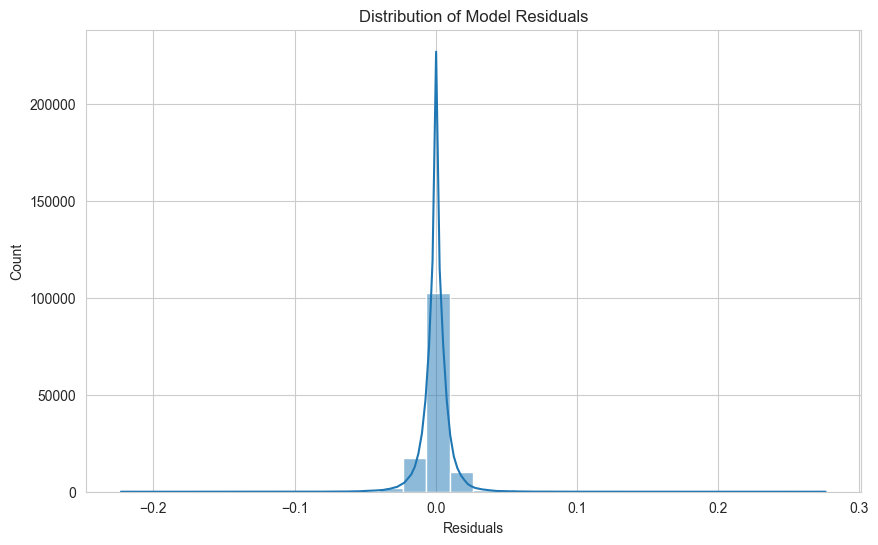

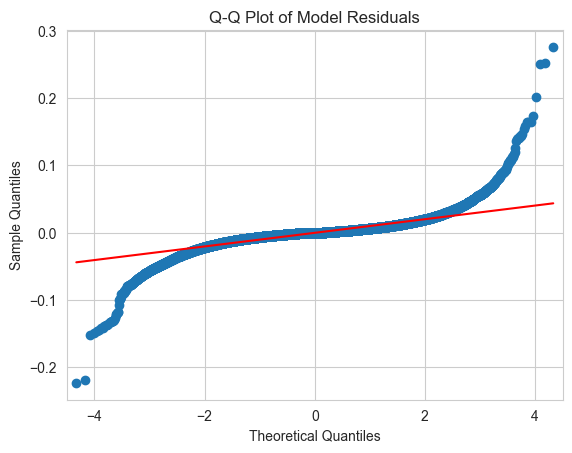

In [22]:
residuals = model.resid

# 1. 绘制直方图和 KDE 曲线
plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Model Residuals")
plt.show()

# 2. 绘制 Q-Q 图，检查正态性
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Model Residuals")
plt.show()

### Evaluation for BTC

In [23]:
btc_data = alphas.loc['BTCUSDT']
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6696 entries, 2024-07-01 01:00:00+00:00 to 2025-04-06 00:00:00+00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ret_01  6696 non-null   float64
 1   ret_02  6696 non-null   float64
 2   ret_03  6696 non-null   float64
 3   ret_04  6696 non-null   float64
 4   ret_05  6696 non-null   float64
 5   ret_12  6696 non-null   float64
 6   ret_24  6696 non-null   float64
 7   ret_48  6696 non-null   float64
 8   ret_72  6696 non-null   float64
 9   Close   6696 non-null   float64
 10  009     6696 non-null   float64
dtypes: float64(11)
memory usage: 627.8 KB


<Axes: xlabel='009', ylabel='Count'>

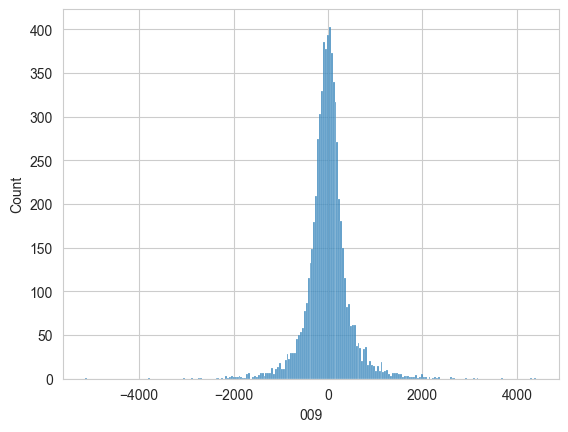

In [24]:
sns.histplot(btc_data[f"{alpha:03}"])

In [25]:
for c in ret_col:
    print(f"Corr between alpha{alpha:03} and {c} is:", btc_data[f"{alpha:03}"].corr(btc_data[c]))

Corr between alpha009 and ret_01 is: 0.018472057581616935
Corr between alpha009 and ret_02 is: 0.006881769217622949
Corr between alpha009 and ret_03 is: 0.022399389846838594
Corr between alpha009 and ret_04 is: 0.021588964309880204
Corr between alpha009 and ret_05 is: 0.014369691499494698
Corr between alpha009 and ret_12 is: 0.019095790006123617
Corr between alpha009 and ret_24 is: 0.03245695264300379
Corr between alpha009 and ret_48 is: 0.018285908131296512
Corr between alpha009 and ret_72 is: 0.008189885832766816
Corr between alpha009 and Close is: -0.009344991459376275


C:\Users\elisa\AppData\Local\Temp\ipykernel_25692\1316720417.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  btc_data['month'] = btc_data.index.to_period('M').astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25692\1316720417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data['month'] = btc_data.index.to_period('M').astype(str)


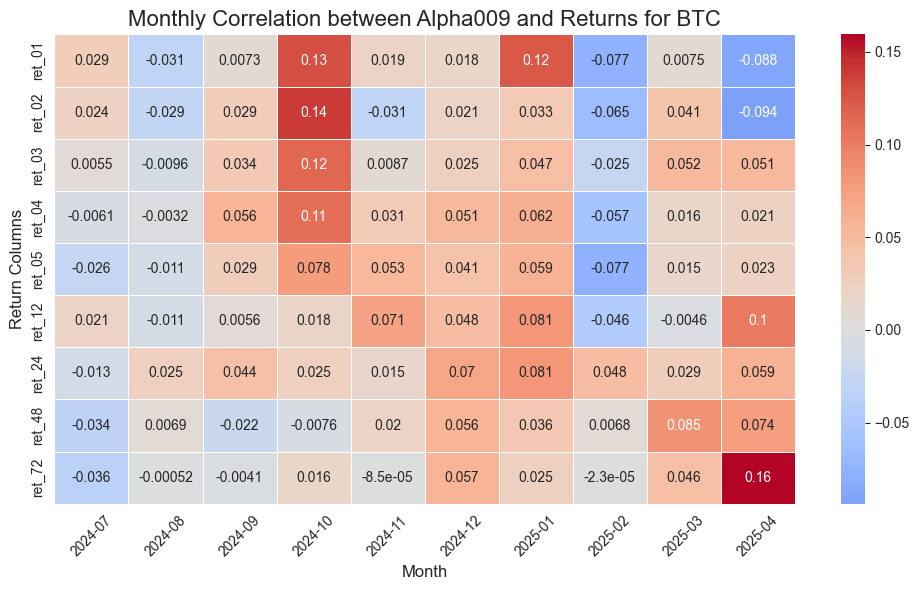

In [26]:
btc_data.index = pd.to_datetime(btc_data.index)

# 创建月份的分组标签（格式如 '2024-07'）
btc_data['month'] = btc_data.index.to_period('M').astype(str)

# 需要分析的收益列
ret_columns = ['ret_01', 'ret_02', 'ret_03', 'ret_04', 'ret_05', 'ret_12', 'ret_24', 'ret_48', 'ret_72']

# 初始化一个DataFrame用于存储相关性结果
months = sorted(btc_data['month'].unique())
correlation_matrix = pd.DataFrame(index=ret_columns, columns=months)

# 按月份计算相关性
for month in months:
    temp_df = btc_data[btc_data['month'] == month]
    for ret in ret_columns:
        corr_value = temp_df[[f'{alpha:03}', ret]].corr().iloc[0, 1]
        correlation_matrix.loc[ret, month] = corr_value

# 转换数据类型为float，方便绘图
correlation_matrix = correlation_matrix.astype(float)

# 使用heatmap可视化
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title(f'Monthly Correlation between Alpha{alpha:03} and Returns for BTC', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Return Columns', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
X = sm.add_constant(btc_data[f"{alpha:03}"])
model = sm.OLS(btc_data['ret_01'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 ret_01   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.285
Date:                Tue, 22 Apr 2025   Prob (F-statistic):              0.131
Time:                        16:48:50   Log-Likelihood:                 25014.
No. Observations:                6696   AIC:                        -5.002e+04
Df Residuals:                    6694   BIC:                        -5.001e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.443e-05   7.06e-05      0.346      0.7

### Evaluation for ETH

In [28]:
eth_data = alphas.loc['ETHUSDT']
eth_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6696 entries, 2024-07-01 01:00:00+00:00 to 2025-04-06 00:00:00+00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ret_01  6696 non-null   float64
 1   ret_02  6696 non-null   float64
 2   ret_03  6696 non-null   float64
 3   ret_04  6696 non-null   float64
 4   ret_05  6696 non-null   float64
 5   ret_12  6696 non-null   float64
 6   ret_24  6696 non-null   float64
 7   ret_48  6696 non-null   float64
 8   ret_72  6696 non-null   float64
 9   Close   6696 non-null   float64
 10  009     6696 non-null   float64
dtypes: float64(11)
memory usage: 627.8 KB


<Axes: xlabel='009', ylabel='Count'>

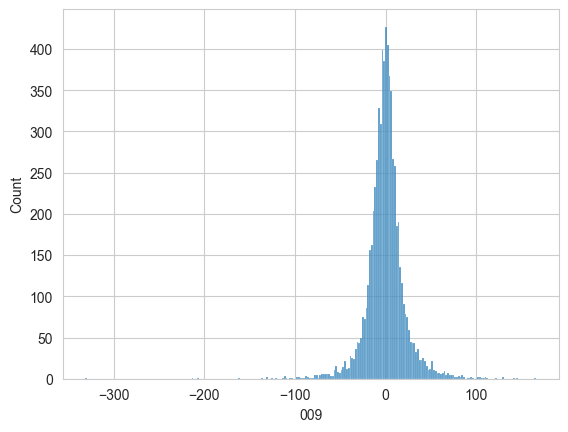

In [29]:
sns.histplot(eth_data[f"{alpha:03}"])

In [30]:
for c in ret_col:
    print(f"Corr between alpha{alpha:03} and {c} is:", eth_data[f"{alpha:03}"].corr(eth_data[c]))

Corr between alpha009 and ret_01 is: 0.03619312951436469
Corr between alpha009 and ret_02 is: 0.022828760347156172
Corr between alpha009 and ret_03 is: 0.013259697443306821
Corr between alpha009 and ret_04 is: 0.004085069185530857
Corr between alpha009 and ret_05 is: 0.002405451434688705
Corr between alpha009 and ret_12 is: 0.011054368777896529
Corr between alpha009 and ret_24 is: 0.0060643605228464185
Corr between alpha009 and ret_48 is: -0.013982489497193714
Corr between alpha009 and ret_72 is: -0.020222237426653935
Corr between alpha009 and Close is: -0.006238536811024619


C:\Users\elisa\AppData\Local\Temp\ipykernel_25692\3977908595.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  eth_data['month'] = eth_data.index.to_period('M').astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25692\3977908595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_data['month'] = eth_data.index.to_period('M').astype(str)


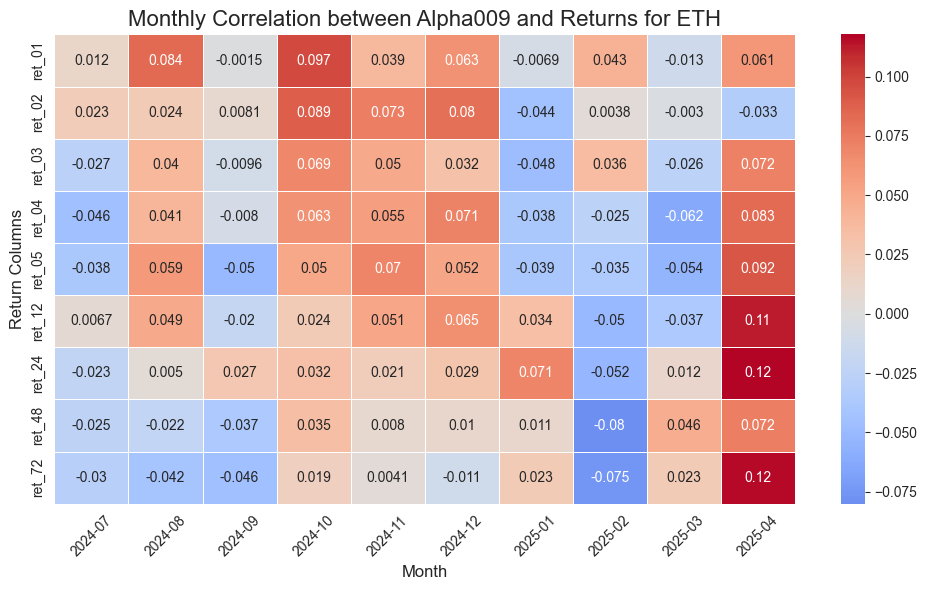

In [31]:
eth_data.index = pd.to_datetime(eth_data.index)

# 创建月份的分组标签（格式如 '2024-07'）
eth_data['month'] = eth_data.index.to_period('M').astype(str)

# 需要分析的收益列
ret_columns = ['ret_01', 'ret_02', 'ret_03', 'ret_04', 'ret_05', 'ret_12', 'ret_24', 'ret_48', 'ret_72']

# 初始化一个DataFrame用于存储相关性结果
months = sorted(eth_data['month'].unique())
correlation_matrix = pd.DataFrame(index=ret_columns, columns=months)

# 按月份计算相关性
for month in months:
    temp_df = eth_data[eth_data['month'] == month]
    for ret in ret_columns:
        corr_value = temp_df[[f"{alpha:003}", ret]].corr().iloc[0, 1]
        correlation_matrix.loc[ret, month] = corr_value

# 转换数据类型为float，方便绘图
correlation_matrix = correlation_matrix.astype(float)

# 使用heatmap可视化
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title(f'Monthly Correlation between Alpha{alpha:003} and Returns for ETH', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Return Columns', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
X = sm.add_constant(eth_data[f"{alpha:03}"])
model = sm.OLS(eth_data['ret_01'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 ret_01   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.780
Date:                Tue, 22 Apr 2025   Prob (F-statistic):            0.00306
Time:                        16:48:58   Log-Likelihood:                 23066.
No. Observations:                6696   AIC:                        -4.613e+04
Df Residuals:                    6694   BIC:                        -4.611e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001   9.44e-05     -1.351      0.1

### Evaluation for ADA

In [33]:
ada_data = alphas.loc['ADAUSDT']
ada_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6696 entries, 2024-07-01 01:00:00+00:00 to 2025-04-06 00:00:00+00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ret_01  6696 non-null   float64
 1   ret_02  6696 non-null   float64
 2   ret_03  6696 non-null   float64
 3   ret_04  6696 non-null   float64
 4   ret_05  6696 non-null   float64
 5   ret_12  6696 non-null   float64
 6   ret_24  6696 non-null   float64
 7   ret_48  6696 non-null   float64
 8   ret_72  6696 non-null   float64
 9   Close   6696 non-null   float64
 10  009     6696 non-null   float64
dtypes: float64(11)
memory usage: 627.8 KB


<Axes: xlabel='009', ylabel='Count'>

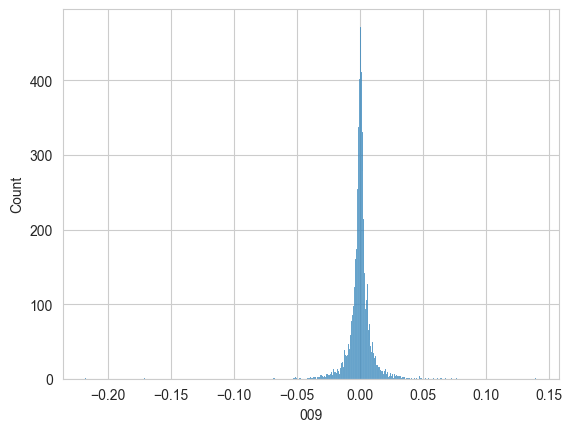

In [34]:
sns.histplot(ada_data[f"{alpha:03}"])

In [35]:
for c in ret_col:
    print(f"Corr between alpha{alpha:03} and {c} is:", ada_data[f"{alpha:03}"].corr(ada_data[c]))

Corr between alpha009 and ret_01 is: -0.027454423050975552
Corr between alpha009 and ret_02 is: -0.012507584070075689
Corr between alpha009 and ret_03 is: -0.003394046513812053
Corr between alpha009 and ret_04 is: -0.006666898606043968
Corr between alpha009 and ret_05 is: -0.004953017040195207
Corr between alpha009 and ret_12 is: 0.0009373743477061566
Corr between alpha009 and ret_24 is: 0.01676649063777487
Corr between alpha009 and ret_48 is: 0.0105207665315154
Corr between alpha009 and ret_72 is: 0.00420887025976441
Corr between alpha009 and Close is: -0.018214552424798112


C:\Users\elisa\AppData\Local\Temp\ipykernel_25692\2821918388.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  ada_data['month'] = ada_data.index.to_period('M').astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25692\2821918388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ada_data['month'] = ada_data.index.to_period('M').astype(str)


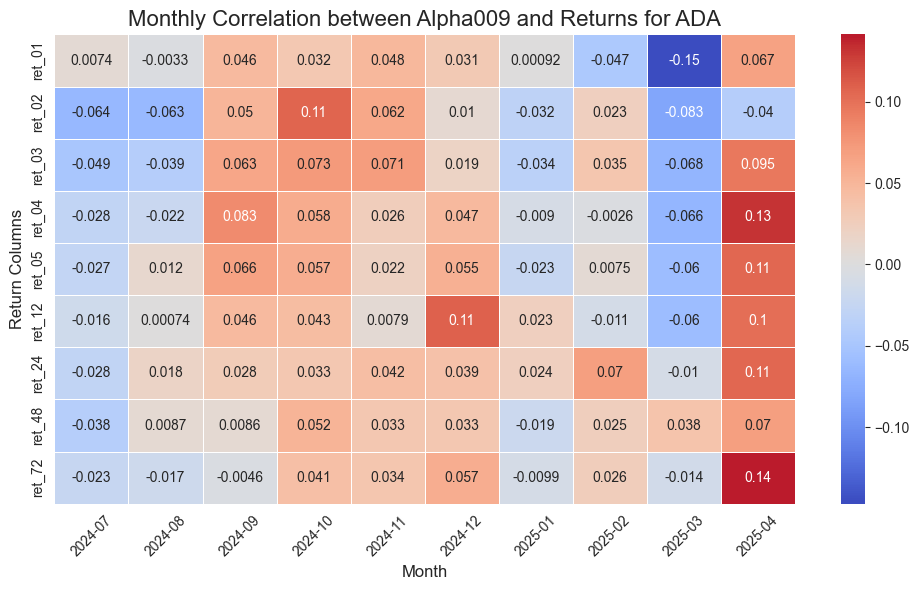

In [36]:
ada_data.index = pd.to_datetime(ada_data.index)

# 创建月份的分组标签（格式如 '2024-07'）
ada_data['month'] = ada_data.index.to_period('M').astype(str)

# 需要分析的收益列
ret_columns = ['ret_01', 'ret_02', 'ret_03', 'ret_04', 'ret_05', 'ret_12', 'ret_24', 'ret_48', 'ret_72']

# 初始化一个DataFrame用于存储相关性结果
months = sorted(ada_data['month'].unique())
correlation_matrix = pd.DataFrame(index=ret_columns, columns=months)

# 按月份计算相关性
for month in months:
    temp_df = ada_data[ada_data['month'] == month]
    for ret in ret_columns:
        corr_value = temp_df[[f"{alpha:003}", ret]].corr().iloc[0, 1]
        correlation_matrix.loc[ret, month] = corr_value

# 转换数据类型为float，方便绘图
correlation_matrix = correlation_matrix.astype(float)

# 使用heatmap可视化
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title(f'Monthly Correlation between Alpha{alpha:003} and Returns for ADA', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Return Columns', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
X = sm.add_constant(ada_data[f"{alpha:03}"])
model = sm.OLS(ada_data['ret_01'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 ret_01   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.049
Date:                Tue, 22 Apr 2025   Prob (F-statistic):             0.0247
Time:                        16:49:10   Log-Likelihood:                 19912.
No. Observations:                6696   AIC:                        -3.982e+04
Df Residuals:                    6694   BIC:                        -3.981e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -7.5e-06      0.000     -0.050      0.9